# Example Walk through of the DS Pipeline

## Planning

Goal: 

- Business objective: reduce churn by 5%
- Project objective: predict with at least 70% accuracy whether a customer will churn

Deliverable: deliver a model with the estimated accuracy score.

Questions to explore:

- Does contract type affect churn?
- Are those with higher monthly charges more likely to churn?
- Does gender play a role in churn?

## Data Acquisition

Here we will acquire data from a cloud SQL database. The connection details are hidden in the `env` python module, and you can see the SQL query used in the cell below.

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import re
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree

import warnings
warnings.filterwarnings("ignore")

import env

In [2]:
url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/telco_churn'

query = '''
        SELECT *
        FROM customers c
        JOIN contract_types ct USING(contract_type_id)
        '''
    
df = pd.read_sql(query, url)
df.head(5)

,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,...,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,payment_type_id,monthly_charges,total_charges,churn,contract_type
0,2,0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,1,...,No,Yes,Yes,No,Yes,2,65.6,593.3,No,One year
1,1,0003-MKNFE,Male,0,No,No,9,Yes,Yes,1,...,No,No,No,Yes,No,2,59.9,542.4,No,Month-to-month
2,1,0004-TLHLJ,Male,0,No,No,4,Yes,No,2,...,Yes,No,No,No,Yes,1,73.9,280.85,Yes,Month-to-month
3,1,0011-IGKFF,Male,1,Yes,No,13,Yes,No,2,...,Yes,No,Yes,Yes,Yes,1,98.0,1237.85,Yes,Month-to-month
4,1,0013-EXCHZ,Female,1,Yes,No,3,Yes,No,2,...,No,Yes,Yes,No,Yes,2,83.9,267.4,Yes,Month-to-month


What does our data look like?

In [3]:
df.head().T

,0,1,2,3,4
contract_type_id,2,1,1,1,1
customer_id,0002-ORFBO,0003-MKNFE,0004-TLHLJ,0011-IGKFF,0013-EXCHZ
gender,Female,Male,Male,Male,Female
senior_citizen,0,0,0,1,1
partner,Yes,No,No,Yes,Yes
dependents,Yes,No,No,No,No
tenure,9,9,4,13,3
phone_service,Yes,Yes,Yes,Yes,Yes
multiple_lines,No,Yes,No,No,No
internet_service_type_id,1,1,2,2,2


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   contract_type_id          7043 non-null   int64  
 1   customer_id               7043 non-null   object 
 2   gender                    7043 non-null   object 
 3   senior_citizen            7043 non-null   int64  
 4   partner                   7043 non-null   object 
 5   dependents                7043 non-null   object 
 6   tenure                    7043 non-null   int64  
 7   phone_service             7043 non-null   object 
 8   multiple_lines            7043 non-null   object 
 9   internet_service_type_id  7043 non-null   int64  
 10  online_security           7043 non-null   object 
 11  online_backup             7043 non-null   object 
 12  device_protection         7043 non-null   object 
 13  tech_support              7043 non-null   object 
 14  streamin

Let's take a look at the distribution of our target, churn.

In [5]:
df.churn.value_counts()

No     5174
Yes    1869
Name: churn, dtype: int64

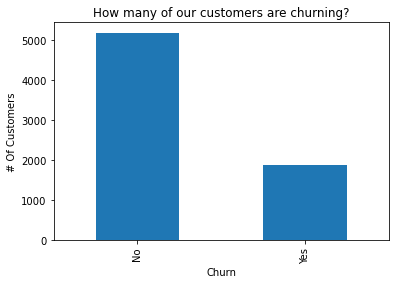

In [6]:
df.churn.value_counts().plot.bar()
plt.title('How many of our customers are churning?')
plt.xlabel('Churn')
plt.ylabel('# Of Customers')
plt.show()

What percent of our customers are currently churning?

In [7]:
round((df.churn == 'Yes').sum() / len(df),2)*100

27.0

## Data Prep

First we'll check for missing values.

In [8]:
df.isnull().sum()

contract_type_id            0
customer_id                 0
gender                      0
senior_citizen              0
partner                     0
dependents                  0
tenure                      0
phone_service               0
multiple_lines              0
internet_service_type_id    0
online_security             0
online_backup               0
device_protection           0
tech_support                0
streaming_tv                0
streaming_movies            0
paperless_billing           0
payment_type_id             0
monthly_charges             0
total_charges               0
churn                       0
contract_type               0
dtype: int64

Seems like there aren't any.

Let's find out what data types we are working with.

In [9]:
df.dtypes

contract_type_id              int64
customer_id                  object
gender                       object
senior_citizen                int64
partner                      object
dependents                   object
tenure                        int64
phone_service                object
multiple_lines               object
internet_service_type_id      int64
online_security              object
online_backup                object
device_protection            object
tech_support                 object
streaming_tv                 object
streaming_movies             object
paperless_billing            object
payment_type_id               int64
monthly_charges             float64
total_charges                object
churn                        object
contract_type                object
dtype: object

Weird that total_charges is not numeric... Let's explore further.

In [10]:
# df.total_charges.astype(float)

Seems like the `total_charges` column contains values that are not numbers. Let's clean those up.

In [11]:
def parse_total_charges(s):
    if re.search(r'^\d+(\.\d+)?$', s):
        return float(s)
    else:
        print(f'"{s}" is not a numeric value! Replacing with null...')
        return np.nan

In [12]:
df.total_charges

0         593.3
1         542.4
2        280.85
3       1237.85
4         267.4
         ...   
7038      742.9
7039     1873.7
7040      92.75
7041    4627.65
7042     3707.6
Name: total_charges, Length: 7043, dtype: object

In [13]:
df.total_charges = df.total_charges.apply(parse_total_charges)

" " is not a numeric value! Replacing with null...
" " is not a numeric value! Replacing with null...
" " is not a numeric value! Replacing with null...
" " is not a numeric value! Replacing with null...
" " is not a numeric value! Replacing with null...
" " is not a numeric value! Replacing with null...
" " is not a numeric value! Replacing with null...
" " is not a numeric value! Replacing with null...
" " is not a numeric value! Replacing with null...
" " is not a numeric value! Replacing with null...
" " is not a numeric value! Replacing with null...


Now let's check the nulls and datatypes now:

In [14]:
pd.concat([df.dtypes.rename('dtype'), df.isna().sum().rename('# of nulls')], axis=1)

,dtype,# of nulls
contract_type_id,int64,0
customer_id,object,0
gender,object,0
senior_citizen,int64,0
partner,object,0
dependents,object,0
tenure,int64,0
phone_service,object,0
multiple_lines,object,0
internet_service_type_id,int64,0


Now we do indeed have 11 missing values in total_charges.

We need to get rid of those nulls. Since there are relatively few of them, we are just going to drop all of them. 

In [15]:
df = df.dropna()

Let's ensure our nulls are gone. 

In [16]:
pd.concat([df.dtypes.rename('dtype'), df.isna().sum().rename('# of nulls')], axis=1)

,dtype,# of nulls
contract_type_id,int64,0
customer_id,object,0
gender,object,0
senior_citizen,int64,0
partner,object,0
dependents,object,0
tenure,int64,0
phone_service,object,0
multiple_lines,object,0
internet_service_type_id,int64,0


### Data Splitting

In [17]:
train, test = train_test_split(df, train_size=.6, random_state=123)
validate, test = train_test_split(test, train_size=.5, random_state=123)

In [18]:
df.shape

(7032, 22)

In [19]:
train.shape

(4219, 22)

In [20]:
validate.shape

(1406, 22)

In [21]:
test.shape

(1407, 22)

We will use ONLY the train data in the exploration section. 

In [22]:
train.head()

,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,...,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,payment_type_id,monthly_charges,total_charges,churn,contract_type
6277,3,8882-TLVRW,Male,0,Yes,Yes,69,No,No phone service,1,...,Yes,Yes,No,No,No,2,39.10,2779.50,No,Two year
5564,1,7839-NUIAA,Female,0,Yes,Yes,61,Yes,Yes,1,...,No,No,No,No,No,1,59.80,3641.50,No,Month-to-month
669,3,0979-MOZQI,Male,0,Yes,No,62,No,No phone service,1,...,No,Yes,Yes,No,Yes,3,39.00,2337.45,No,Two year
698,1,1029-QFBEN,Male,0,No,No,1,Yes,No,3,...,No internet service,No internet service,No internet service,No internet service,No,2,19.55,19.55,Yes,Month-to-month
4308,1,6075-SLNIL,Male,0,No,No,38,Yes,Yes,2,...,Yes,No,No,Yes,Yes,4,95.10,3691.20,No,Month-to-month


## Data Exploration

### Is there a relationship between contract type and churn?

In [23]:
pd.crosstab(train.contract_type, train.churn,).style.background_gradient(cmap='Greens')

churn,No,Yes
contract_type,,
Month-to-month,1309,1014
One year,796,90
Two year,980,30


In [24]:
pd.crosstab(train.contract_type, train.churn,
            normalize='index').style.background_gradient(cmap='Greens')

churn,No,Yes
contract_type,,
Month-to-month,0.563495,0.436505
One year,0.898420,0.101580
Two year,0.970297,0.029703


It definitely seems like customers on a month-to-month contract churn more frequently than the other contract types.

Let's verify it with a chi^2 stats test. 

$H_0$: contract type does not affect churn

$H_a$: contract type does affect churn

In [25]:
observed = pd.crosstab(train.contract_type, train.churn,)
chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < .05:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")  

We reject the null hypothesis


Therefore, we can conclude there is a relationship between contract type and churn

### Is there a relationship between monthly charges and churn?

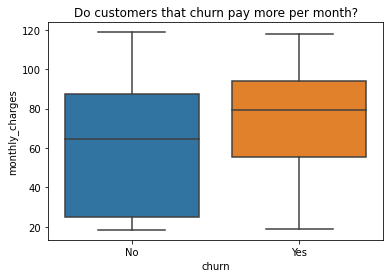

In [26]:
sns.boxplot(data=train, y='monthly_charges', x='churn')
plt.title('Do customers that churn pay more per month?')
plt.show()

It definitely seems like the median monthly charge is higher for customers that have churned compared to those that haven't.

Now let's run our statistic test to ensure this is significant. 

$H_0$: charges of customers who churn equals that of those who don't churn

$H_a$: charges of customers who churn is not equal to that of those who don't churn

In [27]:
churn_sample = train[train.churn == 'Yes'].monthly_charges
no_churn_sample = train[train.churn == 'No'].monthly_charges

t, p = stats.ttest_ind(churn_sample, no_churn_sample)

if p < .05:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")  

We reject the null hypothesis


Therefore, we can conclude that monthly charges effect churn

### Is there a difference in gender between churners and non-churners?

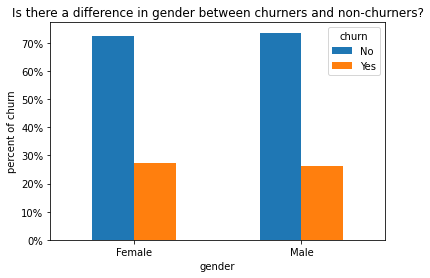

In [28]:
pd.crosstab(train.gender, train.churn, normalize='index').plot.bar(stacked=False)
plt.gca().yaxis.set_major_formatter('{:.0%}'.format)
plt.ylabel('percent of churn')
plt.xticks(rotation=0)
plt.title('Is there a difference in gender between churners and non-churners?')
plt.show()

While there might be some small difference, it seems like gender does not play a significant role in whether or not a customer will churn.

Now let's run our statistic test to ensure this is significant. 

$H_0$: gender is independent of churn

$H_a$: gender is not independent of churn

In [29]:
observed = pd.crosstab(train.gender, train.churn)
chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < .05:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")  

We fail to reject the null hypothesis


Therefore, we can conclude that there gender is indepedent of churn

### Feature Engineering

Based on the results of our exploration, we'll use monthly charges and whether or not a customer is on a month-to-month contract as our features.

To do so, we'll convert the contract-type feature to a 1 or 0 for whether or not the customer is on a month to month contract.

In [30]:
train.contract_type.value_counts()

Month-to-month    2323
Two year          1010
One year           886
Name: contract_type, dtype: int64

In [31]:
train['month_to_month_contract'] = (train.contract_type == 'Month-to-month').astype(int)

In [32]:
train.month_to_month_contract.value_counts()

1    2323
0    1896
Name: month_to_month_contract, dtype: int64

Since we made this new variable in train, we also need to apply it to our validate and test sets.

In [33]:
validate['month_to_month_contract'] = (validate.contract_type == 'Month-to-month').astype(int)
test['month_to_month_contract'] = (test.contract_type == 'Month-to-month').astype(int)

## Modeling

To be able to model, we need to separate our target variable in our train, validate and test sets.

In [34]:
X_train = train.drop(columns='churn')
X_validate = validate.drop(columns='churn')
X_test = test.drop(columns='churn')

y_train = train.churn
y_validate = validate.churn
y_test = test.churn

We decided we are going to use our newly created feature and monthly charges for modeling. 

In [35]:
features = ['monthly_charges', 'month_to_month_contract']

In [36]:
X_train[features].head()

,monthly_charges,month_to_month_contract
6277,39.10,0
5564,59.80,1
669,39.00,0
698,19.55,1
4308,95.10,1


### DecisionTreeClassifier

We'll create several different models and compare their performance.

In [37]:
model1 = DecisionTreeClassifier(max_depth=2)
model1.fit(X_train[features], y_train)

accuracy_train = model1.score(X_train[features], y_train)
accuracy_validate = model1.score(X_validate[features], y_validate)

print(f'''Model 1 Accuracy
 train: {accuracy_train:.2%} 
 validate: {accuracy_validate:.2%}''')

Model 1 Accuracy
 train: 75.23% 
 validate: 75.60%


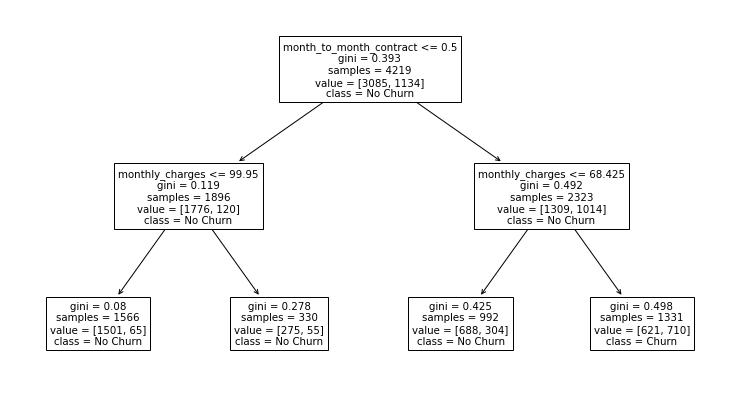

In [38]:
plt.figure(figsize=(13, 7))
plot_tree(model1, feature_names=features, class_names=['No Churn', 'Churn'])
plt.show()

* Traditional: given rule + data, produce answer
* ML: given data + answers, produce rules

In [39]:
model2 = DecisionTreeClassifier(max_depth=5)
model2.fit(X_train[features], y_train)

accuracy_train = model2.score(X_train[features], y_train)
accuracy_validate = model2.score(X_validate[features], y_validate)

print(f'''Model 2 Accuracy
 train: {accuracy_train:.2%} 
 validate: {accuracy_validate:.2%}''')

Model 2 Accuracy
 train: 76.13% 
 validate: 75.04%


In [40]:
model3 = DecisionTreeClassifier(max_depth=10)
model3.fit(X_train[features], y_train)

accuracy_train = model3.score(X_train[features], y_train)
accuracy_validate = model3.score(X_validate[features], y_validate)

print(f'''Model 3 Accuracy
 train: {accuracy_train:.2%} 
 validate: {accuracy_validate:.2%}''')

# print(f'''Model 1 Accuracy
#  train: {accuracy_train:.2%} 
#  ''')

Model 3 Accuracy
 train: 79.14% 
 validate: 73.76%


Looks like model 1 performs the best.

### Testing

In [41]:
accuracy = model1.score(X_test[features], y_test)

print(f'Out of sample accuracy: {accuracy:.2%}')

Out of sample accuracy: 74.06%


## Conclusion

- Contract type and monthly charges seem to be fairly predictive of churn.
- Gender does not seem to be very influential in terms of predicting churn.
- Our model is able to predict whether or not a customer churns based on their monthly charges and contract type with 74% accuracy.

If our model had been used to identify 75% of the 1,869 customers that did churn, we could have predicted churn in 1,400 customers before it happened. Customers predicted to churn could be offered a discount. If only 10% of those customers remained because of the discount, we would have reduced churn by 7.5%, exceeding our target of 5%.